In [3]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [4]:
dataset = 'keypoint.csv'
model_save_path = 'models/keypoint_classifier.hdf5'
tflite_save_path = 'models/keypoint_classifier.tflite'

# Set number of classes

In [5]:
NUM_CLASSES = 12

# Dataset reading

In [6]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [7]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 12)                132       
                                                                 
Total params: 1202 (4.70 KB)
Trainable params: 1202 (4.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [12]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [13]:
es_callback

In [14]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000




1/9 [==>...........................] - ETA: 9s - loss: 2.4777 - accuracy: 0.0625
Epoch 1: saving model to keypoint_classifier.hdf5
9/9 [==============================] - 1s 40ms/step - loss: 2.4974 - accuracy: 0.0880 - val_loss: 2.4911 - val_accuracy: 0.0827
Epoch 2/1000
1/9 [==>...........................] - ETA: 0s - loss: 2.5091 - accuracy: 0.1016
Epoch 2: saving model to keypoint_classifier.hdf5
9/9 [==============================] - 0s 9ms/step - loss: 2.4977 - accuracy: 0.0809 - val_loss: 2.4892 - val_accuracy: 0.0613
Epoch 3/1000
1/9 [==>...........................] - ETA: 0s - loss: 2.4819 - accuracy: 0.0547
Epoch 3: saving model to keypoint_classifier.hdf5
9/9 [==============================] - 0s 8ms/step - loss: 2.5012 - accuracy: 0.0800 - val_loss: 2.4872 - val_accuracy: 0.0720
Epoch 4/1000
1/9 [==>...........................] - ETA: 0s - loss: 2.5026 - accuracy: 0.0938

c:\Users\Ian\git\553.806_Capstone_HandGesture\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 4: saving model to keypoint_classifier.hdf5
9/9 [==============================] - 0s 8ms/step - loss: 2.5006 - accuracy: 0.0809 - val_loss: 2.4854 - val_accuracy: 0.0720
Epoch 5/1000
1/9 [==>...........................] - ETA: 0s - loss: 2.4766 - accuracy: 0.0703
Epoch 5: saving model to keypoint_classifier.hdf5
9/9 [==============================] - 0s 8ms/step - loss: 2.4826 - accuracy: 0.0898 - val_loss: 2.4848 - val_accuracy: 0.0800
Epoch 6/1000
1/9 [==>...........................] - ETA: 0s - loss: 2.4756 - accuracy: 0.1094
Epoch 6: saving model to keypoint_classifier.hdf5
9/9 [==============================] - 0s 8ms/step - loss: 2.4867 - accuracy: 0.0933 - val_loss: 2.4827 - val_accuracy: 0.1280
Epoch 7/1000
1/9 [==>...........................] - ETA: 0s - loss: 2.4971 - accuracy: 0.0938
Epoch 7: saving model to keypoint_classifier.hdf5
9/9 [==============================] - 0s 8ms/step - loss: 2.4885 - accuracy: 0.0853 - val_loss: 2.4816 - val_accuracy: 0.1147
Epoch 8/1

In [15]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

3/3 [==============================] - 0s 4ms/step - loss: 1.8691 - accuracy: 0.3893


In [16]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [17]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 106ms/step
[0.00338712 0.02148774 0.16834259 0.00513236 0.00481326 0.0736201
 0.15309879 0.1408358  0.13072476 0.093023   0.18023582 0.02529871]
10


# Confusion matrix

12/12 [==============================] - 0s 1ms/step


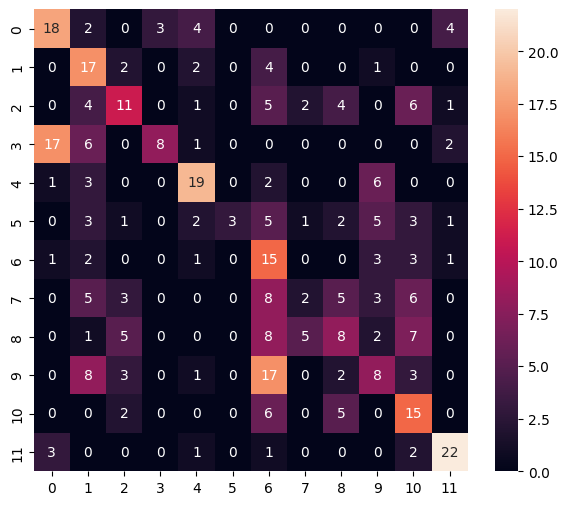

Classification Report
              precision    recall  f1-score   support

           0       0.45      0.58      0.51        31
           1       0.33      0.65      0.44        26
           2       0.41      0.32      0.36        34
           3       0.73      0.24      0.36        34
           4       0.59      0.61      0.60        31
           5       1.00      0.12      0.21        26
           6       0.21      0.58      0.31        26
           7       0.20      0.06      0.10        32
           8       0.31      0.22      0.26        36
           9       0.29      0.19      0.23        42
          10       0.33      0.54      0.41        28
          11       0.71      0.76      0.73        29

    accuracy                           0.39       375
   macro avg       0.46      0.41      0.38       375
weighted avg       0.45      0.39      0.37       375



In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [ ]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

c:\Users\Ian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Ian\AppData\Local\Temp\tmp69b2ci5z\assets


INFO:tensorflow:Assets written to: C:\Users\Ian\AppData\Local\Temp\tmp69b2ci5z\assets


6896

# Inference test

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.00491581 0.00071304 0.00266372 0.0018812  0.00439063 0.04990563
 0.00642677 0.20272893 0.02035344 0.00706662 0.4208745  0.2780797 ]
10
